In [ ]:
!pip install spacy nltk scikit-learn pandas numpy matplotlib
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 21.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import spacy
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

nltk.download('stopwords')
from nltk.corpus import stopwords

nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df = pd.read_csv("UpdatedResumeDataSet.csv")
df.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


In [ ]:
df.columns

Index(['Category', 'Resume'], dtype='object')

In [ ]:
df.isnull().sum()

,0
Category,0
Resume,0


In [ ]:
df = df.drop_duplicates()
df.reset_index(drop=True, inplace=True)

df.shape

(166, 2)

In [ ]:
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    doc = nlp(text)
    tokens = []

    for token in doc:
        if token.text not in stop_words:
            tokens.append(token.lemma_)

    return " ".join(tokens)

In [ ]:
df['cleaned_resume'] = df['Resume'].apply(preprocess_text)

df[['Resume', 'cleaned_resume']].head()

,Resume,cleaned_resume
0,Skills * Programming Languages: Python (pandas...,skill programming language python panda...
1,Education Details \r\nMay 2013 to May 2017 B.E...,education detail \r\n may may b e ...
2,"Areas of Interest Deep Learning, Control Syste...",area interest deep learning control system d...
3,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,skill r python sap hana ta...
4,"Education Details \r\n MCA YMCAUST, Faridab...",education detail \r\n mca ymcaust farid...


In [ ]:
job_description = """
Looking for a Data Science candidate with strong knowledge in Python,
Machine Learning, Deep Learning, SQL, and data analysis.
Good communication skills required.
"""

In [ ]:
cleaned_job = preprocess_text(job_description)

cleaned_job

'\n look data science candidate strong knowledge python \n machine learning   deep learning   sql   datum analysis \n good communication skill require \n'

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Combine resumes + job description
all_documents = df['cleaned_resume'].tolist()
all_documents.append(cleaned_job)

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(all_documents)

tfidf_matrix.shape

(167, 5946)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Separate resume vectors and job vector
resume_vectors = tfidf_matrix[:-1]
job_vector = tfidf_matrix[-1]

# Calculate similarity
similarity_scores = cosine_similarity(resume_vectors, job_vector)

similarity_scores[:5]

array([[0.11871968],
       [0.06103896],
       [0.16551699],
       [0.11844368],
       [0.08706458]])

In [ ]:
# Convert similarity scores to 1D list
df['similarity_score'] = similarity_scores.flatten()

df.head()

,Category,Resume,cleaned_resume,similarity_score
0,Data Science,Skills * Programming Languages: Python (pandas...,skill programming language python panda...,0.118720
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,education detail \r\n may may b e ...,0.061039
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",area interest deep learning control system d...,0.165517
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,skill r python sap hana ta...,0.118444
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",education detail \r\n mca ymcaust farid...,0.087065


In [ ]:
# Sort candidates by highest similarity score
ranked_df = df.sort_values(by='similarity_score', ascending=False)

# Show Top 10 best matches
ranked_df[['Category', 'similarity_score']].head(10)

,Category,similarity_score
7,Data Science,0.389574
8,Data Science,0.374293
6,Data Science,0.260412
9,Data Science,0.251410
134,Database,0.176663
2,Data Science,0.165517
91,Automation Testing,0.137855
5,Data Science,0.132103
0,Data Science,0.118720
3,Data Science,0.118444


In [ ]:
# Define required skills from job description
required_skills = [
    "python",
    "machine learning",
    "deep learning",
    "sql",
    "data analysis",
    "communication"
]

In [ ]:
def check_skill_match(resume_text):
    present = []
    missing = []

    for skill in required_skills:
        if skill in resume_text:
            present.append(skill)
        else:
            missing.append(skill)

    return present, missing

In [ ]:
top_candidates = ranked_df.head(5).copy()

top_candidates['present_skills'], top_candidates['missing_skills'] = zip(
    *top_candidates['cleaned_resume'].apply(check_skill_match)
)

top_candidates[['similarity_score', 'present_skills', 'missing_skills']]

,similarity_score,present_skills,missing_skills
7,0.389574,"[python, machine learning, deep learning, sql,...",[data analysis]
8,0.374293,"[python, machine learning, deep learning, sql]","[data analysis, communication]"
6,0.260412,"[python, machine learning]","[deep learning, sql, data analysis, communicat..."
9,0.251410,"[python, machine learning, communication]","[deep learning, sql, data analysis]"
134,0.176663,"[python, machine learning, sql, communication]","[deep learning, data analysis]"


In [ ]:
for i, row in top_candidates.iterrows():
    print("--------------------------------------------------")
    print(f"Candidate Index: {i}")
    print(f"Similarity Score: {round(row['similarity_score'], 3)}")
    print(f"Matched Skills: {row['present_skills']}")
    print(f"Missing Skills: {row['missing_skills']}")

--------------------------------------------------
Candidate Index: 7
Similarity Score: 0.39
Matched Skills: ['python', 'machine learning', 'deep learning', 'sql', 'communication']
Missing Skills: ['data analysis']
--------------------------------------------------
Candidate Index: 8
Similarity Score: 0.374
Matched Skills: ['python', 'machine learning', 'deep learning', 'sql']
Missing Skills: ['data analysis', 'communication']
--------------------------------------------------
Candidate Index: 6
Similarity Score: 0.26
Matched Skills: ['python', 'machine learning']
Missing Skills: ['deep learning', 'sql', 'data analysis', 'communication']
--------------------------------------------------
Candidate Index: 9
Similarity Score: 0.251
Matched Skills: ['python', 'machine learning', 'communication']
Missing Skills: ['deep learning', 'sql', 'data analysis']
--------------------------------------------------
Candidate Index: 134
Similarity Score: 0.177
Matched Skills: ['python', 'machine learni

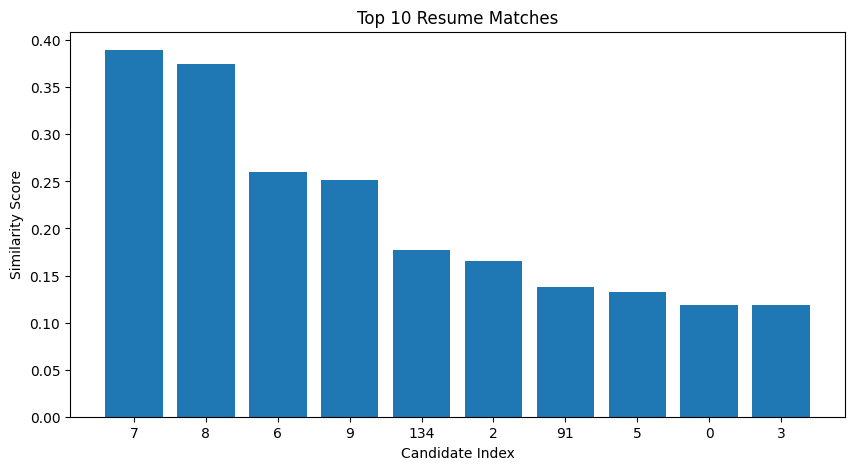

In [ ]:
import matplotlib.pyplot as plt

# Take top 10 candidates
top10 = ranked_df.head(10)

plt.figure(figsize=(10,5))
plt.bar(range(len(top10)), top10['similarity_score'])
plt.xticks(range(len(top10)), top10.index)
plt.xlabel("Candidate Index")
plt.ylabel("Similarity Score")
plt.title("Top 10 Resume Matches")
plt.show()

In [ ]:
# Define skill weights (importance level)
skill_weights = {
    "python": 2.0,
    "machine learning": 2.0,
    "deep learning": 1.8,
    "sql": 1.5,
    "data analysis": 1.5,
    "communication": 1.0
}

In [ ]:
def calculate_weighted_score(resume_text):
    score = 0

    for skill, weight in skill_weights.items():
        if skill in resume_text:
            score += weight

    return score

In [ ]:
df['weighted_skill_score'] = df['cleaned_resume'].apply(calculate_weighted_score)

# Combine similarity + weighted score
df['final_score'] = df['similarity_score'] + (df['weighted_skill_score'] * 0.05)

# Rank again
ranked_weighted = df.sort_values(by='final_score', ascending=False)

ranked_weighted[['similarity_score', 'weighted_skill_score', 'final_score']].head(10)

,similarity_score,weighted_skill_score,final_score
7,0.389574,8.3,0.804574
8,0.374293,7.3,0.739293
134,0.176663,6.5,0.501663
9,0.251410,5.0,0.501410
6,0.260412,4.0,0.460412
3,0.118444,6.3,0.433444
2,0.165517,5.3,0.430517
0,0.118720,5.3,0.383720
138,0.079471,5.5,0.354471
139,0.107198,4.5,0.332198


In [ ]:
# Save full ranked results
ranked_weighted.to_csv("final_ranked_candidates.csv", index=False)

print("File saved successfully.")

File saved successfully.


In [ ]:
# Fit vectorizer only on resumes once
vectorizer = TfidfVectorizer()
resume_tfidf = vectorizer.fit_transform(df['cleaned_resume'])

In [ ]:
vectorizer = TfidfVectorizer()
resume_tfidf = vectorizer.fit_transform(df['cleaned_resume'])

In [ ]:
job_description_input = "Data Engineer with strong Python, SQL and ETL experience"

cleaned_input = preprocess_text(job_description_input)

# Transform only (DO NOT FIT AGAIN)
job_vector = vectorizer.transform([cleaned_input])

# Compute similarity
similarity_new = cosine_similarity(resume_tfidf, job_vector)

df['dynamic_similarity'] = similarity_new.flatten()

dynamic_ranked = df.sort_values(by='dynamic_similarity', ascending=False)

dynamic_ranked[['Category', 'dynamic_similarity']].head(5)

,Category,dynamic_similarity
142,ETL Developer,0.247552
145,ETL Developer,0.200306
143,ETL Developer,0.189763
146,ETL Developer,0.180130
103,Python Developer,0.167084


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# Ask for dynamic input
job_description_input = input("Enter Job Description and press Enter: ")

# Clean it
cleaned_input = preprocess_text(job_description_input)

# Transform only (no refit)
job_vector = vectorizer.transform([cleaned_input])

# Compute similarity
similarity_new = cosine_similarity(resume_tfidf, job_vector)

# Store results
df['dynamic_similarity'] = similarity_new.flatten()

# Rank
dynamic_ranked = df.sort_values(by='dynamic_similarity', ascending=False)

# Show top 5
dynamic_ranked[['Category', 'dynamic_similarity']].head(5)

Enter Job Description and press Enter: Data engineer with strong python


,Category,dynamic_similarity
105,Python Developer,0.220488
108,Python Developer,0.207566
103,Python Developer,0.186895
2,Data Science,0.171295
9,Data Science,0.169744


In [ ]:
top_results = dynamic_ranked.head(5).copy()

top_results['similarity_percent'] = (top_results['dynamic_similarity'] * 100).round(2)

top_results['resume_preview'] = top_results['Resume'].str[:150]

top_results[['Category', 'similarity_percent', 'resume_preview']]

,Category,similarity_percent,resume_preview
105,Python Developer,22.05,TECHNICAL PROFICIENCIES Platform: Ubuntu/Fedor...
108,Python Developer,20.76,â¢ Operating Systems: Windows â¢ Others: MS ...
103,Python Developer,18.69,Technical Skills / Responsibilities: â¢ Hands...
2,Data Science,17.13,"Areas of Interest Deep Learning, Control Syste..."
9,Data Science,16.97,Expertise â Data and Quantitative Analysis â...
